#Exploratory Data Analysis (EDA) of Google Health Searches#
Dataset is located at: https://www.kaggle.com/GoogleNewsLab/health-searches-us-county 
 * Make sure you have downloaded and unzipped the data first. 

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests
import zipfile
import io


This cell with open a window wher you can select the data csv file you downloaded.

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving RegionalInterestByConditionOverTime.csv to RegionalInterestByConditionOverTime (1).csv
User uploaded file "RegionalInterestByConditionOverTime.csv" with length 85807 bytes


In [5]:
file='RegionalInterestByConditionOverTime.csv'
healthSearchData=pd.read_csv(file)
healthSearchData.head()

,dma,geoCode,2004+cancer,2004+cardiovascular,2004+stroke,2004+depression,2004+rehab,2004+vaccine,2004+diarrhea,2004+obesity,2004+diabetes,2005+cancer,2005+cardiovascular,2005+stroke,2005+depression,2005+rehab,2005+vaccine,2005+diarrhea,2005+obesity,2005+diabetes,2006+cancer,2006+cardiovascular,2006+stroke,2006+depression,2006+rehab,2006+vaccine,2006+diarrhea,2006+obesity,2006+diabetes,2007+cancer,2007+cardiovascular,2007+stroke,2007+depression,2007+rehab,2007+vaccine,2007+diarrhea,2007+obesity,2007+diabetes,2008+cancer,2008+cardiovascular,...,2013+vaccine,2013+diarrhea,2013+obesity,2013+diabetes,2014+cancer,2014+cardiovascular,2014+stroke,2014+depression,2014+rehab,2014+vaccine,2014+diarrhea,2014+obesity,2014+diabetes,2015+cancer,2015+cardiovascular,2015+stroke,2015+depression,2015+rehab,2015+vaccine,2015+diarrhea,2015+obesity,2015+diabetes,2016+cancer,2016+cardiovascular,2016+stroke,2016+depression,2016+rehab,2016+vaccine,2016+diarrhea,2016+obesity,2016+diabetes,2017+cancer,2017+cardiovascular,2017+stroke,2017+depression,2017+rehab,2017+vaccine,2017+diarrhea,2017+obesity,2017+diabetes
0,Portland-Auburn ME,500,44,6,17,39,21,31,14,29,38,70,16,38,11,27,36,26,14,23,55,23,26,25,38,48,48,19,44,70,31,56,38,37,42,22,24,56,68,22,...,70,64,52,66,79,44,70,72,70,72,61,51,75,67,43,61,70,67,64,68,48,73,69,38,70,64,60,64,69,49,81,70,37,83,64,56,76,66,47,80
1,New York NY,501,47,6,13,38,16,33,12,27,32,63,15,35,10,22,29,23,15,19,49,18,18,20,26,38,37,22,33,64,29,43,34,36,41,18,26,48,64,18,...,60,58,44,58,71,33,45,53,58,57,56,39,62,64,36,44,55,53,58,56,46,63,68,41,47,53,51,64,57,49,77,70,34,53,56,53,79,56,52,78
2,Binghamton NY,502,48,3,16,50,12,37,24,31,37,62,8,44,13,25,21,23,24,18,54,19,26,27,20,35,34,30,26,61,20,56,43,28,45,25,43,54,65,15,...,66,65,52,70,80,36,63,74,50,66,75,65,72,64,31,59,69,46,73,84,67,75,74,33,66,66,44,72,79,70,74,68,24,71,69,44,77,78,61,72
3,Macon GA,503,44,14,14,37,19,49,14,29,31,55,25,48,10,29,33,22,23,22,44,24,23,18,39,50,46,29,39,65,42,54,35,40,42,16,36,48,66,23,...,60,62,62,64,72,56,69,60,71,53,68,54,78,66,60,62,68,66,53,71,60,73,63,59,65,56,69,56,66,51,78,53,38,62,46,60,47,53,41,66
4,Philadelphia PA,504,52,7,16,41,23,36,14,30,37,73,17,39,12,32,33,24,18,23,57,24,23,23,40,42,44,24,40,72,34,49,38,46,47,21,31,55,75,23,...,69,68,51,68,81,39,57,62,83,68,66,44,70,71,45,51,63,77,69,67,56,72,74,42,56,59,72,70,70,52,80,75,35,61,62,75,84,69,56,78


In [0]:
# Create a region column by extracting state, then map state to U.S. region
temp= [] # initialize empty list

for i in healthSearchData['dma']:
  temp.append(i[-2:]) # add last two letters of dma to temp list

healthSearchData['state_abbrev'] = temp # create new column 'state_abbrev'


In [7]:
# Fix index 11 state_abbrev, dma formatting different from other dma's
healthSearchData.set_value(11, 'state_abbrev', 'DC')
healthSearchData.iloc[11]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.


dma                    Washington DC (Hagerstown MD)
geoCode                                          511
2004+cancer                                       47
2004+cardiovascular                                5
2004+stroke                                       15
                                   ...              
2017+vaccine                                      79
2017+diarrhea                                     55
2017+obesity                                      59
2017+diabetes                                     73
state_abbrev                                      DC
Name: 11, Length: 129, dtype: object

In [0]:
# Dictionary of state abbreviations to region ('West', 'Midwest', 'Northeast', 'South', and 'O' = other)

states = {
        'AK': 'West',
        'AL': 'South',
        'AR': 'South',
        'AS': 'O',
        'AZ': 'West',
        'CA': 'West',
        'CO': 'West',
        'CT': 'Northeast',
        'DC': 'South',
        'DE': 'Northeast',
        'FL': 'South',
        'GA': 'South',
        'GU': 'O',
        'HI': 'West',
        'IA': 'Midwest',
        'ID': 'West',
        'IL': 'Midwest',
        'IN': 'Midwest',
        'KS': 'Midwest',
        'KY': 'South',
        'LA': 'South',
        'MA': 'Northeast',
        'MD': 'South',
        'ME': 'Northeast',
        'MI': 'West',
        'MN': 'Midwest',
        'MO': 'Midwest',
        'MP': 'O',
        'MS': 'South',
        'MT': 'West',
        'NA': 'O',
        'NC': 'South',
        'ND': 'Midwest',
        'NE': 'Midwest',
        'NH': 'Northeast',
        'NJ': 'Northeast',
        'NM': 'West',
        'NV': 'West',
        'NY': 'Northeast',
        'OH': 'Midwest',
        'OK': 'South',
        'OR': 'West',
        'PA': 'Northeast',
        'PR': 'O',
        'RI': 'Northeast',
        'SC': 'South',
        'SD': 'Midwest',
        'TN': 'South',
        'TX': 'South',
        'UT': 'West',
        'VA': 'South',
        'VI': 'O',
        'VT': 'Northeast',
        'WA': 'West',
        'WI': 'Midwest',
        'WV': 'South',
        'WY': 'West'
}


In [0]:
# Create a column 'region' that maps state abbreviation to region

healthSearchData['region'] = healthSearchData['state_abbrev'].map(states)

In [10]:
healthSearchData.head()

,dma,geoCode,2004+cancer,2004+cardiovascular,2004+stroke,2004+depression,2004+rehab,2004+vaccine,2004+diarrhea,2004+obesity,2004+diabetes,2005+cancer,2005+cardiovascular,2005+stroke,2005+depression,2005+rehab,2005+vaccine,2005+diarrhea,2005+obesity,2005+diabetes,2006+cancer,2006+cardiovascular,2006+stroke,2006+depression,2006+rehab,2006+vaccine,2006+diarrhea,2006+obesity,2006+diabetes,2007+cancer,2007+cardiovascular,2007+stroke,2007+depression,2007+rehab,2007+vaccine,2007+diarrhea,2007+obesity,2007+diabetes,2008+cancer,2008+cardiovascular,...,2013+obesity,2013+diabetes,2014+cancer,2014+cardiovascular,2014+stroke,2014+depression,2014+rehab,2014+vaccine,2014+diarrhea,2014+obesity,2014+diabetes,2015+cancer,2015+cardiovascular,2015+stroke,2015+depression,2015+rehab,2015+vaccine,2015+diarrhea,2015+obesity,2015+diabetes,2016+cancer,2016+cardiovascular,2016+stroke,2016+depression,2016+rehab,2016+vaccine,2016+diarrhea,2016+obesity,2016+diabetes,2017+cancer,2017+cardiovascular,2017+stroke,2017+depression,2017+rehab,2017+vaccine,2017+diarrhea,2017+obesity,2017+diabetes,state_abbrev,region
0,Portland-Auburn ME,500,44,6,17,39,21,31,14,29,38,70,16,38,11,27,36,26,14,23,55,23,26,25,38,48,48,19,44,70,31,56,38,37,42,22,24,56,68,22,...,52,66,79,44,70,72,70,72,61,51,75,67,43,61,70,67,64,68,48,73,69,38,70,64,60,64,69,49,81,70,37,83,64,56,76,66,47,80,ME,Northeast
1,New York NY,501,47,6,13,38,16,33,12,27,32,63,15,35,10,22,29,23,15,19,49,18,18,20,26,38,37,22,33,64,29,43,34,36,41,18,26,48,64,18,...,44,58,71,33,45,53,58,57,56,39,62,64,36,44,55,53,58,56,46,63,68,41,47,53,51,64,57,49,77,70,34,53,56,53,79,56,52,78,NY,Northeast
2,Binghamton NY,502,48,3,16,50,12,37,24,31,37,62,8,44,13,25,21,23,24,18,54,19,26,27,20,35,34,30,26,61,20,56,43,28,45,25,43,54,65,15,...,52,70,80,36,63,74,50,66,75,65,72,64,31,59,69,46,73,84,67,75,74,33,66,66,44,72,79,70,74,68,24,71,69,44,77,78,61,72,NY,Northeast
3,Macon GA,503,44,14,14,37,19,49,14,29,31,55,25,48,10,29,33,22,23,22,44,24,23,18,39,50,46,29,39,65,42,54,35,40,42,16,36,48,66,23,...,62,64,72,56,69,60,71,53,68,54,78,66,60,62,68,66,53,71,60,73,63,59,65,56,69,56,66,51,78,53,38,62,46,60,47,53,41,66,GA,South
4,Philadelphia PA,504,52,7,16,41,23,36,14,30,37,73,17,39,12,32,33,24,18,23,57,24,23,23,40,42,44,24,40,72,34,49,38,46,47,21,31,55,75,23,...,51,68,81,39,57,62,83,68,66,44,70,71,45,51,63,77,69,67,56,72,74,42,56,59,72,70,70,52,80,75,35,61,62,75,84,69,56,78,PA,Northeast


In [0]:
# Drop the 'geoCode' column

healthSearchData = healthSearchData.drop('geoCode', axis=1)

In [12]:
healthSearchData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Columns: 129 entries, dma to region
dtypes: int64(126), object(3)
memory usage: 211.8+ KB


In [13]:
healthSearchData.describe()

,2004+cancer,2004+cardiovascular,2004+stroke,2004+depression,2004+rehab,2004+vaccine,2004+diarrhea,2004+obesity,2004+diabetes,2005+cancer,2005+cardiovascular,2005+stroke,2005+depression,2005+rehab,2005+vaccine,2005+diarrhea,2005+obesity,2005+diabetes,2006+cancer,2006+cardiovascular,2006+stroke,2006+depression,2006+rehab,2006+vaccine,2006+diarrhea,2006+obesity,2006+diabetes,2007+cancer,2007+cardiovascular,2007+stroke,2007+depression,2007+rehab,2007+vaccine,2007+diarrhea,2007+obesity,2007+diabetes,2008+cancer,2008+cardiovascular,2008+stroke,2008+depression,...,2013+vaccine,2013+diarrhea,2013+obesity,2013+diabetes,2014+cancer,2014+cardiovascular,2014+stroke,2014+depression,2014+rehab,2014+vaccine,2014+diarrhea,2014+obesity,2014+diabetes,2015+cancer,2015+cardiovascular,2015+stroke,2015+depression,2015+rehab,2015+vaccine,2015+diarrhea,2015+obesity,2015+diabetes,2016+cancer,2016+cardiovascular,2016+stroke,2016+depression,2016+rehab,2016+vaccine,2016+diarrhea,2016+obesity,2016+diabetes,2017+cancer,2017+cardiovascular,2017+stroke,2017+depression,2017+rehab,2017+vaccine,2017+diarrhea,2017+obesity,2017+diabetes
count,210.000000,210.000000,210.000000,210.00000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,...,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,43.904762,7.433333,17.642857,45.62381,18.890476,32.476190,16.280952,34.261905,38.042857,62.909524,18.671429,44.619048,12.242857,23.823810,29.342857,24.771429,21.519048,23.238095,49.214286,21.557143,24.519048,24.133333,30.747619,38.152381,41.747619,28.871429,39.323810,62.871429,31.976190,55.290476,38.947619,34.461905,40.928571,20.285714,35.204762,54.628571,63.985714,21.480952,60.609524,32.009524,...,62.628571,68.609524,54.333333,68.523810,72.433333,41.052381,61.271429,63.342857,59.604762,61.690476,68.352381,46.833333,71.266667,64.657143,45.580952,56.914286,65.733333,56.033333,62.385714,69.476190,57.828571,71.957143,64.938095,45.728571,63.561905,60.780952,50.861905,62.985714,72.476190,51.761905,77.823810,64.709524,35.923810,70.838095,62.828571,52.928571,72.800000,72.723810,51.761905,77.309524
std,7.618944,7.909647,8.135284,13.71572,10.157723,14.768773,11.449582,16.136765,10.017357,8.869948,14.289275,11.669189,6.800863,10.332853,12.005843,12.140925,10.511881,7.094743,7.561346,11.451962,8.205035,7.798376,11.870035,13.964604,14.710870,12.048055,8.735338,9.616953,13.285039,11.098791,8.388995,9.847691,11.263255,7.596542,13.282034,11.031713,8.381729,10.857146,13.608677,7.537460,...,10.163503,9.583174,15.612023,8.850805,8.031507,14.328415,10.315021,9.587999,14.069920,11.051615,10.266293,14.107782,9.446669,7.233400,15.474183,9.734872,10.655786,13.776890,12.239194,10.832872,15.754369,9.505127,6.515420,14.273730,10.137735,8.009541,13.238879,9.974359,9.566784,14.244632,8.494434,6.436023,12.521136,10.800606,8.539755,14.795242,10.983154,10.453813,13.846751,8.935409
min,27.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,30.

The data here has a range of 0-100, and is described on Google Search API as an 'interest score'. Scores are proportional to the fraction of all searches, so a score of 100 represents very high interest, and a score of 50 is half as popular as the previous search. A score of 0 means that there was not enough data.

One of the things to be really careful with in interpreting this data is that we are unable to get the total count of searches. We only have proportional data, which means that a larger city with a score of 50 for a particular search such as 'cancer' would get a lower score than a smaller city where $\frac{3}{4}$ of searches were 'cancer' would get a score of 75. It is unclear from data source what the total search count is out of - is it of all Google searches, or just the searches that are in this dataset ('cancer', 'stroke', 'cardiovascular', 'diabetes', 'obesity', 'depression', 'vaccine', 'rehab', and 'diarrhea').

The best way to use this data would be to look at relative increases and decreases in the interest scores. For example:
* How does Cancer search interest change over time? 
* Are there any patterns in how it varies by region? 
* Of the searches, which search is the most popular?

It is also unclear if a search query such as 'diabetes' involves all variations of the queries like 'Diabetes Type 1' or 'Diabetes Type 2', or does it strictly include queries with just the word 'diabetes'?

<Figure size 432x288 with 0 Axes>

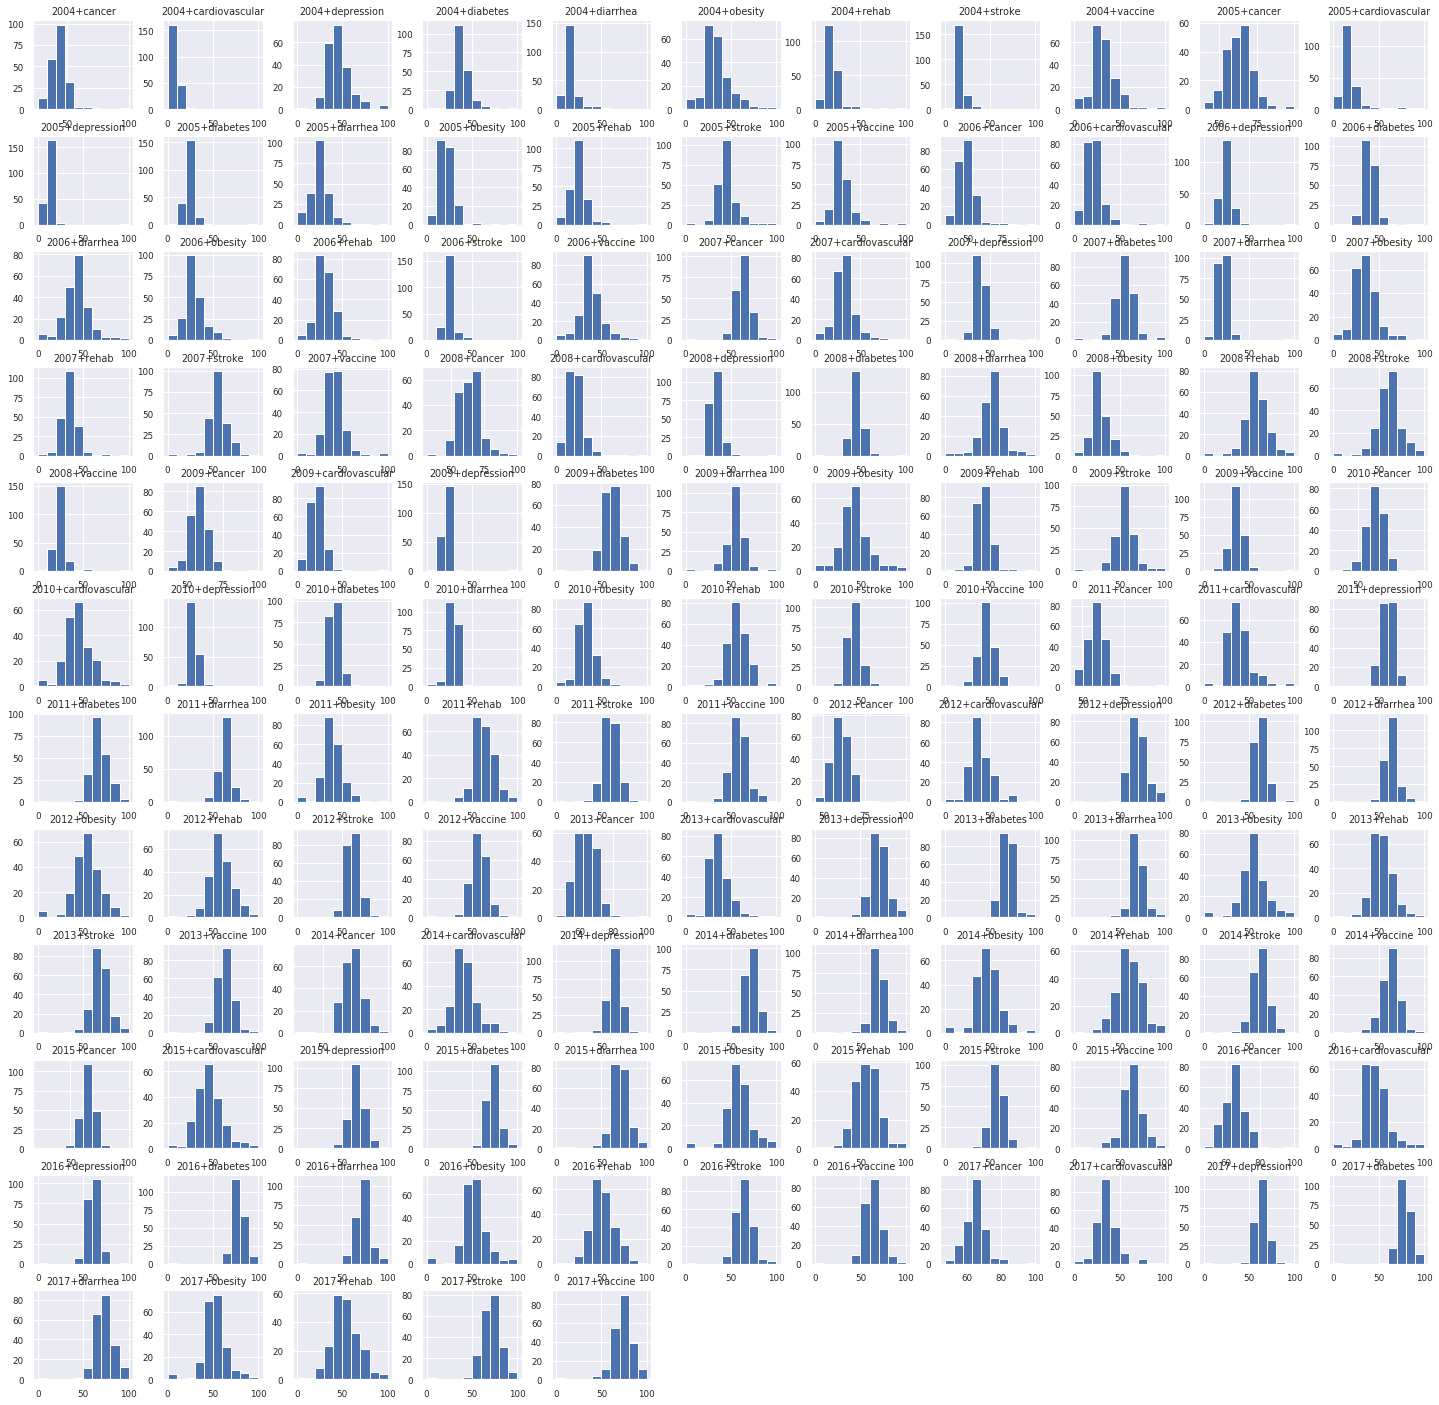

In [14]:
# Histogram for all columns of data
sns.set(font_scale=0.8)
fig = plt.gcf()

hist = healthSearchData.hist(bins=10,figsize =(25,25))
fig.tight_layout()

# Boxplot and Swarmplot

In [15]:
healthSearchData.head()

,dma,2004+cancer,2004+cardiovascular,2004+stroke,2004+depression,2004+rehab,2004+vaccine,2004+diarrhea,2004+obesity,2004+diabetes,2005+cancer,2005+cardiovascular,2005+stroke,2005+depression,2005+rehab,2005+vaccine,2005+diarrhea,2005+obesity,2005+diabetes,2006+cancer,2006+cardiovascular,2006+stroke,2006+depression,2006+rehab,2006+vaccine,2006+diarrhea,2006+obesity,2006+diabetes,2007+cancer,2007+cardiovascular,2007+stroke,2007+depression,2007+rehab,2007+vaccine,2007+diarrhea,2007+obesity,2007+diabetes,2008+cancer,2008+cardiovascular,2008+stroke,...,2013+obesity,2013+diabetes,2014+cancer,2014+cardiovascular,2014+stroke,2014+depression,2014+rehab,2014+vaccine,2014+diarrhea,2014+obesity,2014+diabetes,2015+cancer,2015+cardiovascular,2015+stroke,2015+depression,2015+rehab,2015+vaccine,2015+diarrhea,2015+obesity,2015+diabetes,2016+cancer,2016+cardiovascular,2016+stroke,2016+depression,2016+rehab,2016+vaccine,2016+diarrhea,2016+obesity,2016+diabetes,2017+cancer,2017+cardiovascular,2017+stroke,2017+depression,2017+rehab,2017+vaccine,2017+diarrhea,2017+obesity,2017+diabetes,state_abbrev,region
0,Portland-Auburn ME,44,6,17,39,21,31,14,29,38,70,16,38,11,27,36,26,14,23,55,23,26,25,38,48,48,19,44,70,31,56,38,37,42,22,24,56,68,22,66,...,52,66,79,44,70,72,70,72,61,51,75,67,43,61,70,67,64,68,48,73,69,38,70,64,60,64,69,49,81,70,37,83,64,56,76,66,47,80,ME,Northeast
1,New York NY,47,6,13,38,16,33,12,27,32,63,15,35,10,22,29,23,15,19,49,18,18,20,26,38,37,22,33,64,29,43,34,36,41,18,26,48,64,18,48,...,44,58,71,33,45,53,58,57,56,39,62,64,36,44,55,53,58,56,46,63,68,41,47,53,51,64,57,49,77,70,34,53,56,53,79,56,52,78,NY,Northeast
2,Binghamton NY,48,3,16,50,12,37,24,31,37,62,8,44,13,25,21,23,24,18,54,19,26,27,20,35,34,30,26,61,20,56,43,28,45,25,43,54,65,15,62,...,52,70,80,36,63,74,50,66,75,65,72,64,31,59,69,46,73,84,67,75,74,33,66,66,44,72,79,70,74,68,24,71,69,44,77,78,61,72,NY,Northeast
3,Macon GA,44,14,14,37,19,49,14,29,31,55,25,48,10,29,33,22,23,22,44,24,23,18,39,50,46,29,39,65,42,54,35,40,42,16,36,48,66,23,58,...,62,64,72,56,69,60,71,53,68,54,78,66,60,62,68,66,53,71,60,73,63,59,65,56,69,56,66,51,78,53,38,62,46,60,47,53,41,66,GA,South
4,Philadelphia PA,52,7,16,41,23,36,14,30,37,73,17,39,12,32,33,24,18,23,57,24,23,23,40,42,44,24,40,72,34,49,38,46,47,21,31,55,75,23,59,...,51,68,81,39,57,62,83,68,66,44,70,71,45,51,63,77,69,67,56,72,74,42,56,59,72,70,70,52,80,75,35,61,62,75,84,69,56,78,PA,Northeast


In [16]:
# Create 'cancer' search dataframe with columns for year, count, region.  
years = []
cancer_all = pd.DataFrame()
for col in healthSearchData.columns:
    if '+' and 'cancer' in col:
        year = col.split('+')[0]
        years.append(year)
        add_col = healthSearchData[col] 
        cancer_all = pd.concat([cancer_all, add_col], axis=1)

# Rename columns with years only
cancer_all.columns = years
cancer_all

,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,44,70,55,70,68,61,65,65,67,71,79,67,69,70
1,47,63,49,64,64,58,62,56,58,64,71,64,68,70
2,48,62,54,61,65,58,64,60,62,68,80,64,74,68
3,44,55,44,65,66,53,62,59,59,62,72,66,63,53
4,52,73,57,72,75,65,70,66,69,75,81,71,74,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,35,55,39,53,56,50,56,52,53,55,64,57,57,53
206,40,60,45,58,59,51,57,53,56,59,68,61,58,59
207,34,54,42,51,52,48,54,45,49,56,66,61,55,56
208,36,45,44,59,56,52,55,52,56,58,63,62,59,58


In [17]:
# Add 'region' column
cancer_all['region'] = healthSearchData['region']
cancer_all.head()

,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,region
0,44,70,55,70,68,61,65,65,67,71,79,67,69,70,Northeast
1,47,63,49,64,64,58,62,56,58,64,71,64,68,70,Northeast
2,48,62,54,61,65,58,64,60,62,68,80,64,74,68,Northeast
3,44,55,44,65,66,53,62,59,59,62,72,66,63,53,South
4,52,73,57,72,75,65,70,66,69,75,81,71,74,75,Northeast


In [18]:
# Melt dataframe to have only columns 'region', 'year', and 'value'
melted_df = pd.melt(cancer_all, id_vars='region', var_name='year' )
melted_df

,region,year,value
0,Northeast,2004,44
1,Northeast,2004,47
2,Northeast,2004,48
3,South,2004,44
4,Northeast,2004,52
...,...,...,...
2935,West,2017,53
2936,West,2017,59
2937,West,2017,56
2938,West,2017,58


Text(0.5, 1.0, 'Cancer Search Interest Scores')

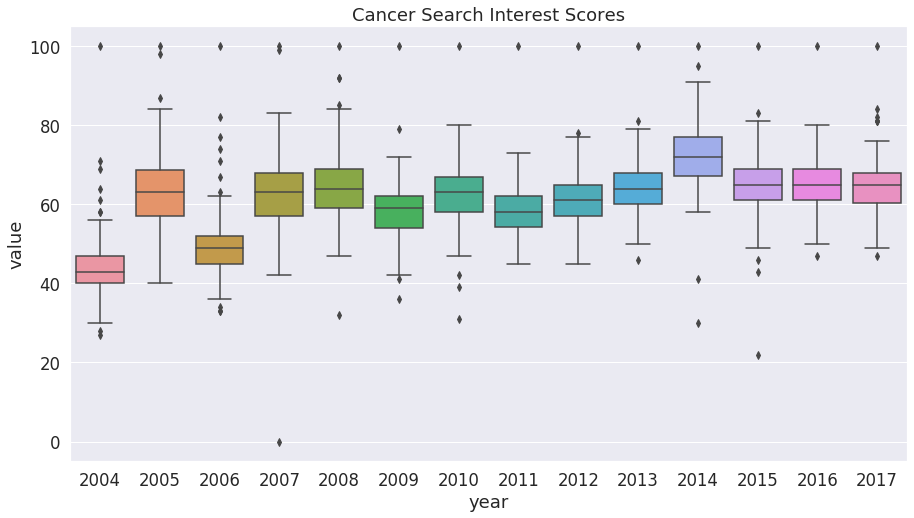

In [19]:
# Box plot
sns.set(font_scale=1.5)
fig = plt.gcf()
fig.set_size_inches(15, 8)
sns.boxplot("year", "value", data=melted_df)
plt.title('Cancer Search Interest Scores')

Text(0.5, 1.0, 'Cancer Search Interest Scores')

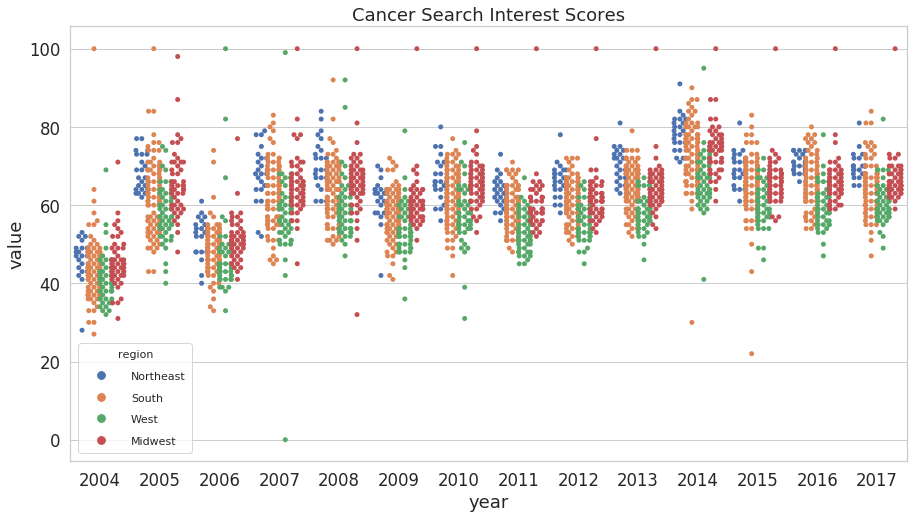

In [20]:
# Swarm plot
fig = plt.gcf()
fig.set_size_inches(15, 8)

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

s = sns.swarmplot(x = 'year', y='value', hue='region', data=melted_df, dodge=True)
plt.setp(s.get_legend().get_texts(), fontsize='11') # for legend text
plt.setp(s.get_legend().get_title(), fontsize='11') # for legend title
plt.title('Cancer Search Interest Scores')


In [21]:
cancer_all.describe()

,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,43.904762,62.909524,49.214286,62.871429,63.985714,58.004762,62.600000,58.423810,60.700000,63.942857,72.433333,64.657143,64.938095,64.709524
std,7.618944,8.869948,7.561346,9.616953,8.381729,6.836783,7.592618,6.313683,6.220855,6.413694,8.031507,7.233400,6.515420,6.436023
min,27.000000,40.000000,33.000000,0.000000,32.000000,36.000000,31.000000,45.000000,45.000000,46.000000,30.000000,22.000000,47.000000,47.000000
25%,40.000000,57.000000,45.000000,57.000000,59.000000,54.000000,58.000000,54.250000,57.000000,60.000000,67.250000,61.000000,61.000000,60.250000
50%,43.000000,63.000000,49.000000,63.000000,64.000000,59.000000,63.000000,58.000000,61.000000,64.000000,72.000000,65.000000,65.000000,65.000000
75%,47.000000,68.750000,52.000000,68.000000,69.000000,62.000000,67.000000,62.000000,65.000000,68.000000,77.000000,69.000000,69.000000,68.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


Text(0.5, 1.0, 'Diabetes Search Interest Scores')

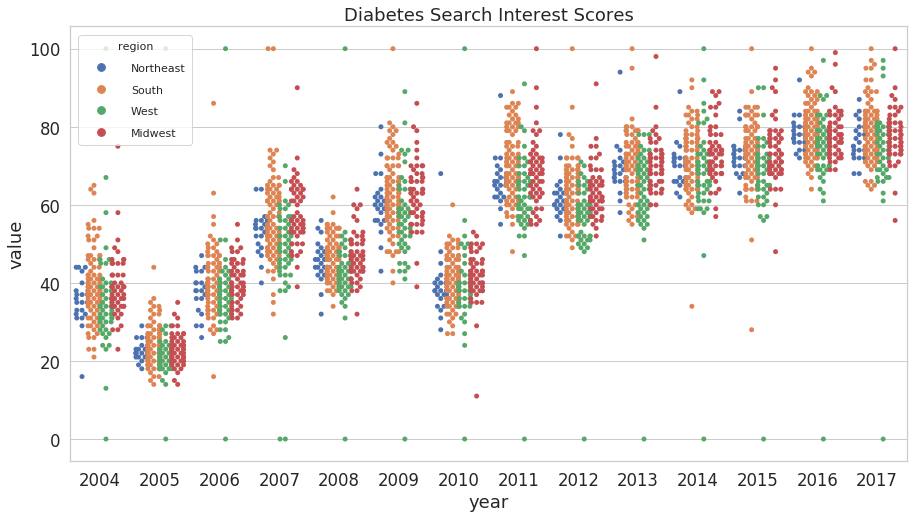

In [22]:
# Create 'diabetes' search dataframe with columns for year, count, region.  
years = []
db_all = pd.DataFrame()
for col in healthSearchData.columns:
    if '+' and 'diabetes' in col:
        year = col.split('+')[0]
        years.append(year)
        add_col = healthSearchData[col] 
        db_all = pd.concat([db_all, add_col], axis=1)

# Rename columns with years only
db_all.columns = years

# Create 'region' column
db_all['region'] = healthSearchData['region']

# Melt dataframe to have only columns 'region', 'year', and 'value'
melted_df = pd.melt(db_all, id_vars='region', var_name='year' )

# Swarm Plot
fig = plt.gcf()
fig.set_size_inches(15, 8)

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

s = sns.swarmplot(x = 'year', y='value', hue='region', data=melted_df, dodge=True)
plt.setp(s.get_legend().get_texts(), fontsize='11') # for legend text
plt.setp(s.get_legend().get_title(), fontsize='11') # for legend title
plt.title('Diabetes Search Interest Scores')


Text(0.5, 1.0, 'Stroke Search Interest Scores')

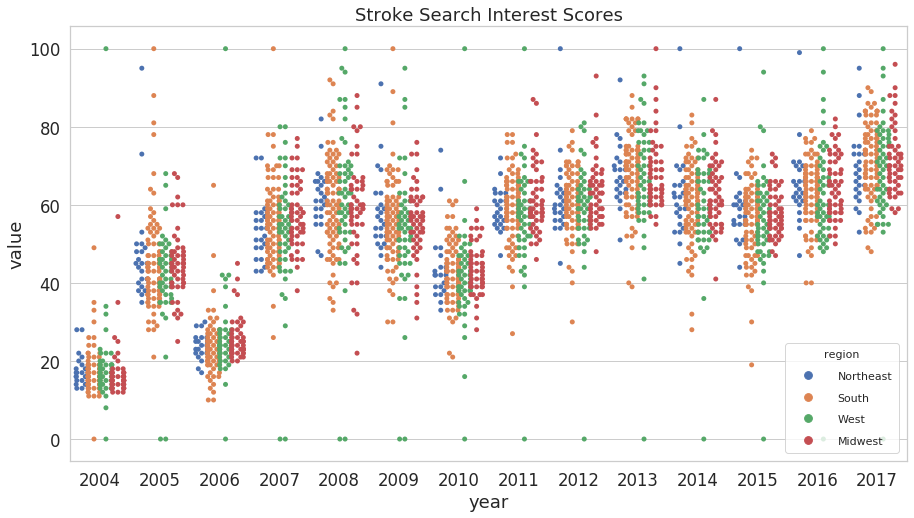

In [23]:
# Create 'stroke' search dataframe with columns for year, count, region.  
years = []
stroke_all = pd.DataFrame()
for col in healthSearchData.columns:
    if '+' and 'stroke' in col:
        year = col.split('+')[0]
        years.append(year)
        add_col = healthSearchData[col] 
        stroke_all = pd.concat([stroke_all, add_col], axis=1)

# Rename columns with years only
stroke_all.columns = years

# Create 'region' column
stroke_all['region'] = healthSearchData['region']

# Melt dataframe to have only columns 'region', 'year', and 'value'
melted_df = pd.melt(stroke_all, id_vars='region', var_name='year' )

# Swarm Plot
fig = plt.gcf()
fig.set_size_inches(15, 8)

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

#sns.boxplot("year", "value", data=melted_df, boxprops={'facecolor':'None'})
#s = sns.swarmplot(x = 'year', y='value', hue='region', data=melted_df, dodge=True, zorder=0.5)
s = sns.swarmplot(x = 'year', y='value', hue='region', data=melted_df, dodge=True)
plt.setp(s.get_legend().get_texts(), fontsize='11') # for legend text
plt.setp(s.get_legend().get_title(), fontsize='11') # for legend title
plt.title('Stroke Search Interest Scores')


Text(0.5, 1.0, 'Stroke Search Interest Scores')

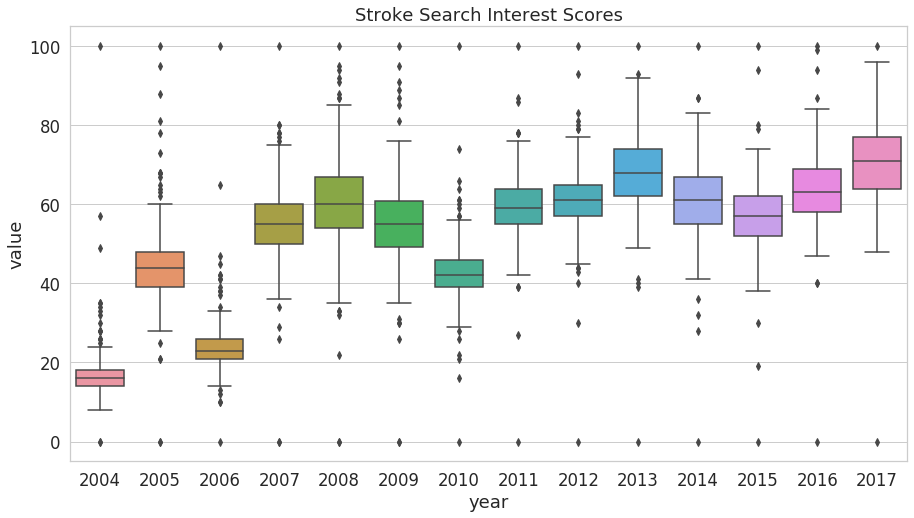

In [24]:
# Box plot
fig = plt.gcf()
fig.set_size_inches(15, 8)
sns.boxplot("year", "value", data=melted_df)
plt.title('Stroke Search Interest Scores')

# Total Interest by Region

Not sure if this metric is useful...

In [25]:
region_sum = healthSearchData.groupby('region').sum()
region_sum

,2004+cancer,2004+cardiovascular,2004+stroke,2004+depression,2004+rehab,2004+vaccine,2004+diarrhea,2004+obesity,2004+diabetes,2005+cancer,2005+cardiovascular,2005+stroke,2005+depression,2005+rehab,2005+vaccine,2005+diarrhea,2005+obesity,2005+diabetes,2006+cancer,2006+cardiovascular,2006+stroke,2006+depression,2006+rehab,2006+vaccine,2006+diarrhea,2006+obesity,2006+diabetes,2007+cancer,2007+cardiovascular,2007+stroke,2007+depression,2007+rehab,2007+vaccine,2007+diarrhea,2007+obesity,2007+diabetes,2008+cancer,2008+cardiovascular,2008+stroke,2008+depression,...,2013+vaccine,2013+diarrhea,2013+obesity,2013+diabetes,2014+cancer,2014+cardiovascular,2014+stroke,2014+depression,2014+rehab,2014+vaccine,2014+diarrhea,2014+obesity,2014+diabetes,2015+cancer,2015+cardiovascular,2015+stroke,2015+depression,2015+rehab,2015+vaccine,2015+diarrhea,2015+obesity,2015+diabetes,2016+cancer,2016+cardiovascular,2016+stroke,2016+depression,2016+rehab,2016+vaccine,2016+diarrhea,2016+obesity,2016+diabetes,2017+cancer,2017+cardiovascular,2017+stroke,2017+depression,2017+rehab,2017+vaccine,2017+diarrhea,2017+obesity,2017+diabetes
region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Midwest,2325,456,866,2621,870,1585,946,1841,1997,3354,1053,2292,667,1154,1408,1246,1178,1172,2615,1153,1304,1354,1558,2007,2247,1619,2052,3344,1722,2940,2199,1585,2256,1076,2053,2958,3354,1066,3023,1772,...,3277,3605,3065,3596,3799,2124,3199,3410,2853,3253,3603,2547,3740,3396,2450,2966,3583,2678,3333,3683,3193,3756,3378,2355,3300,3295,2286,3380,3828,2830,4003,3401,1800,3658,3395,2415,3814,3932,2830,3960
Northeast,1065,156,408,1112,500,933,362,916,817,1573,407,1088,288,593,771,603,524,519,1193,475,547,594,710,1024,945,705,869,1563,627,1232,973,870,994,476,855,1223,1626,441,1424,799,...,1583,1569,1362,1592,1808,890,1438,1595,1513,1538,1537,1200,1617,1592,961,1363,1629,1421,1617,1654,1452,1668,1628,968,1502,1508,1317,1574,1691,1325,1802,1611,746,1596,1566,1353,1868,1679,1287,1756
South,3812,652,1511,3680,1835,2712,1350,2872,3431,5439,1822,3949,961,2288,2628,2216,1882,2095,4224,2107,2020,1932,3047,3177,3628,2512,3540,5501,3181,4854,3158,3342,3506,1853,2932,4937,5553,2205,5249,2566,...,5323,6087,4576,6085,6349,4063,5314,5285,5697,5129,6101,3902,6261,5658,4436,4879,5461,5390,4889,6090,4875,6366,5717,4458,5507,5118,5042,5158,6353,4334,6917,5616,3571,6239,5243,5282,6016,6358,4365,6881
West,2018,297,920,2168,762,1590,761,1566,1744,2845,639,2041,655,968,1355,1137,935,1094,2303,792,1278,1188,1142,1804,1947,1227,1797,2795,1185,2585,1849,1440,1839,855,1553,2354,2904,799,3032,1585,...,2969,3147,2407,3117,3255,1544,2916,3012,2454,3035,3113,2186,3348,2932,1725,2744,3131,2278,3262,3163,2624,3321,2914,1822,3039,2843,2036,3115,3348,2381,3621,2961,1427,3383,2990,2065,3590,3303,2388,3638


In [26]:
# Total search scores for all years

for i in range(len(region_sum)):
  print(region_sum.index[i], region_sum.iloc[i].sum())

Midwest 321917
Northeast 147644
South 540278
West 277785


In [27]:
# Create new column 'Total', total search score per region for all years

region_sum.loc[:, 'Total']= region_sum.sum(axis=1)
region_sum


,2004+cancer,2004+cardiovascular,2004+stroke,2004+depression,2004+rehab,2004+vaccine,2004+diarrhea,2004+obesity,2004+diabetes,2005+cancer,2005+cardiovascular,2005+stroke,2005+depression,2005+rehab,2005+vaccine,2005+diarrhea,2005+obesity,2005+diabetes,2006+cancer,2006+cardiovascular,2006+stroke,2006+depression,2006+rehab,2006+vaccine,2006+diarrhea,2006+obesity,2006+diabetes,2007+cancer,2007+cardiovascular,2007+stroke,2007+depression,2007+rehab,2007+vaccine,2007+diarrhea,2007+obesity,2007+diabetes,2008+cancer,2008+cardiovascular,2008+stroke,2008+depression,...,2013+diarrhea,2013+obesity,2013+diabetes,2014+cancer,2014+cardiovascular,2014+stroke,2014+depression,2014+rehab,2014+vaccine,2014+diarrhea,2014+obesity,2014+diabetes,2015+cancer,2015+cardiovascular,2015+stroke,2015+depression,2015+rehab,2015+vaccine,2015+diarrhea,2015+obesity,2015+diabetes,2016+cancer,2016+cardiovascular,2016+stroke,2016+depression,2016+rehab,2016+vaccine,2016+diarrhea,2016+obesity,2016+diabetes,2017+cancer,2017+cardiovascular,2017+stroke,2017+depression,2017+rehab,2017+vaccine,2017+diarrhea,2017+obesity,2017+diabetes,Total
region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Midwest,2325,456,866,2621,870,1585,946,1841,1997,3354,1053,2292,667,1154,1408,1246,1178,1172,2615,1153,1304,1354,1558,2007,2247,1619,2052,3344,1722,2940,2199,1585,2256,1076,2053,2958,3354,1066,3023,1772,...,3605,3065,3596,3799,2124,3199,3410,2853,3253,3603,2547,3740,3396,2450,2966,3583,2678,3333,3683,3193,3756,3378,2355,3300,3295,2286,3380,3828,2830,4003,3401,1800,3658,3395,2415,3814,3932,2830,3960,321917
Northeast,1065,156,408,1112,500,933,362,916,817,1573,407,1088,288,593,771,603,524,519,1193,475,547,594,710,1024,945,705,869,1563,627,1232,973,870,994,476,855,1223,1626,441,1424,799,...,1569,1362,1592,1808,890,1438,1595,1513,1538,1537,1200,1617,1592,961,1363,1629,1421,1617,1654,1452,1668,1628,968,1502,1508,1317,1574,1691,1325,1802,1611,746,1596,1566,1353,1868,1679,1287,1756,147644
South,3812,652,1511,3680,1835,2712,1350,2872,3431,5439,1822,3949,961,2288,2628,2216,1882,2095,4224,2107,2020,1932,3047,3177,3628,2512,3540,5501,3181,4854,3158,3342,3506,1853,2932,4937,5553,2205,5249,2566,...,6087,4576,6085,6349,4063,5314,5285,5697,5129,6101,3902,6261,5658,4436,4879,5461,5390,4889,6090,4875,6366,5717,4458,5507,5118,5042,5158,6353,4334,6917,5616,3571,6239,5243,5282,6016,6358,4365,6881,540278
West,2018,297,920,2168,762,1590,761,1566,1744,2845,639,2041,655,968,1355,1137,935,1094,2303,792,1278,1188,1142,1804,1947,1227,1797,2795,1185,2585,1849,1440,1839,855,1553,2354,2904,799,3032,1585,...,3147,2407,3117,3255,1544,2916,3012,2454,3035,3113,2186,3348,2932,1725,2744,3131,2278,3262,3163,2624,3321,2914,1822,3039,2843,2036,3115,3348,2381,3621,2961,1427,3383,2990,2065,3590,3303,2388,3638,277785


In [0]:
# Find the total number of searches per year for each region
# region_count dictionary, keys = disease, year

region_count = {}
for col in region_sum.columns:
    if '+' in col:
        year = col.split('+')[0]
        disease = col.split('+')[-1]
        if not disease in region_count:
            region_count[disease] = {}
        if not year in region_count[disease]:
            region_count[disease][year] = region_sum[col]

In [29]:
region_count.keys()

dict_keys(['cancer', 'cardiovascular', 'stroke', 'depression', 'rehab', 'vaccine', 'diarrhea', 'obesity', 'diabetes'])

In [0]:
# n_by_year dictionary, key = year, region
n_by_year = {}

for yr in region_count['cancer'].keys():
  temp = []
  for dis in region_count.keys():
    temp.append(region_count[dis][yr])
  yr_total = sum(temp)
  n_by_year[yr] = yr_total
  
#n_by_year['2004']['Midwest']

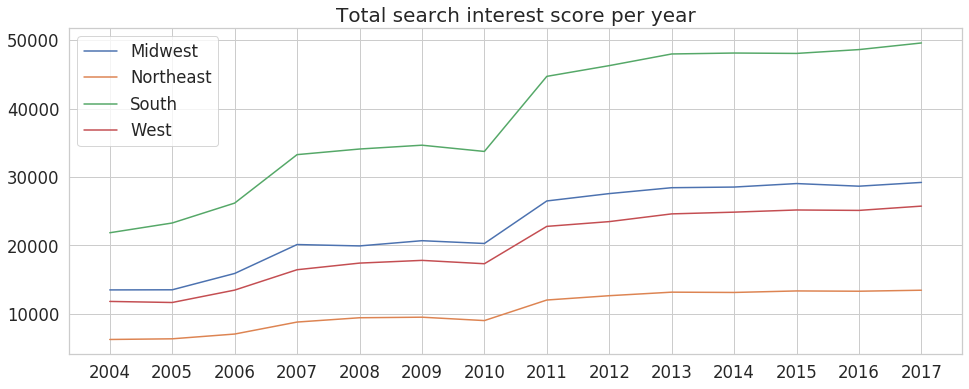

In [31]:
plt.figure(figsize=(16, 6))
ax = plt.subplot(111)
plt.title("Total search interest score per year", fontsize=20)

ax.set_xticks(range(0,14))
ax.set_xticklabels(list(n_by_year.keys()))

tempList = list(n_by_year.values())
_= plt.plot(tempList)

plt.legend(n_by_year['2005'].keys(), loc='best')

In [32]:
n_by_year.keys()

dict_keys(['2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])

In [33]:
n_by_year['2011']

region
Midwest      26498
Northeast    12031
South        44694
West         22786
dtype: int64

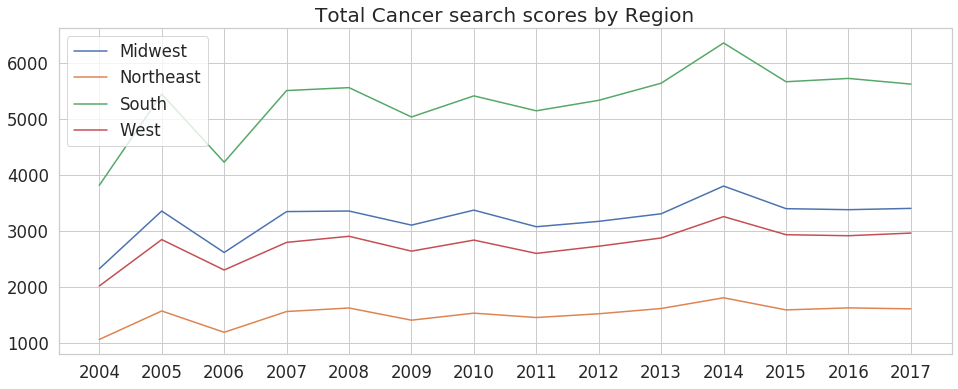

In [34]:
plt.figure(figsize=(16, 6))
ax = plt.subplot(111)
plt.title("Total Cancer search scores by Region", fontsize=20)

ax.set_xticks(range(0,14))
ax.set_xticklabels(list(region_count['cancer'].keys()))
#lh = {}

#for disease in yearWiseMeam:
tempList = list(region_count['cancer'].values())
#for yr in templist
_ = plt.plot(tempList)

plt.legend(region_count['cancer']['2005'].keys(), loc='best')

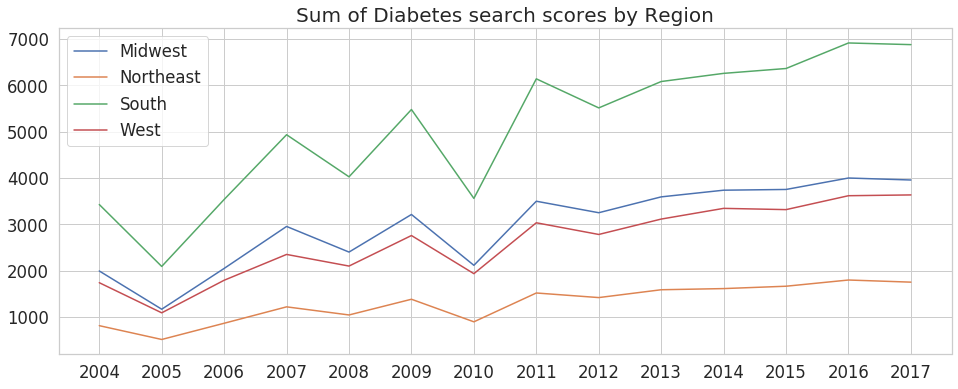

In [35]:
plt.figure(figsize=(16, 6))
ax = plt.subplot(111)
plt.title("Sum of Diabetes search scores by Region", fontsize=20)

ax.set_xticks(range(0,14))
ax.set_xticklabels(list(region_count['diabetes'].keys()))
#lh = {}

#for disease in yearWiseMeam:
tempList = list(region_count['diabetes'].values())
#for yr in templist
_ = plt.plot(tempList)

plt.legend(region_count['diabetes']['2005'].keys(), loc='best')

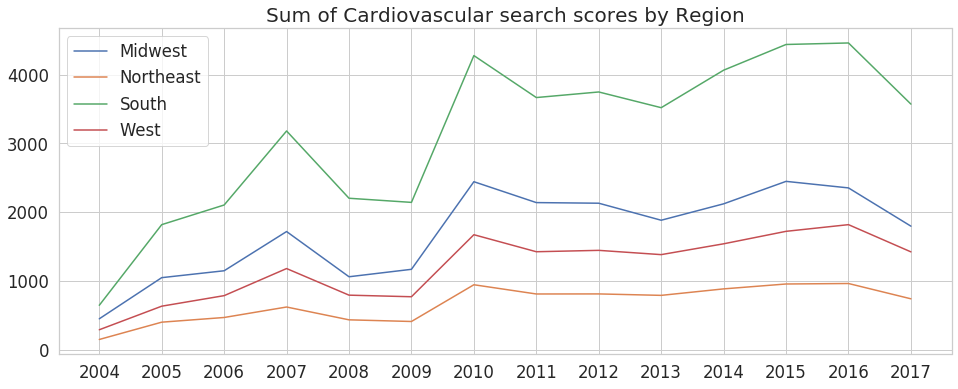

In [36]:
plt.figure(figsize=(16, 6))
ax = plt.subplot(111)
plt.title("Sum of Cardiovascular search scores by Region", fontsize=20)

ax.set_xticks(range(0,14))
ax.set_xticklabels(list(region_count['cardiovascular'].keys()))
#lh = {}

#for disease in yearWiseMeam:
tempList = list(region_count['cardiovascular'].values())
#for yr in templist
_ = plt.plot(tempList)

plt.legend(region_count['cardiovascular']['2005'].keys(), loc='best')

# Mean Interest by Region

In [37]:
# Regional mean search count per city
region_mean = healthSearchData.groupby('region').mean()
region_mean

,2004+cancer,2004+cardiovascular,2004+stroke,2004+depression,2004+rehab,2004+vaccine,2004+diarrhea,2004+obesity,2004+diabetes,2005+cancer,2005+cardiovascular,2005+stroke,2005+depression,2005+rehab,2005+vaccine,2005+diarrhea,2005+obesity,2005+diabetes,2006+cancer,2006+cardiovascular,2006+stroke,2006+depression,2006+rehab,2006+vaccine,2006+diarrhea,2006+obesity,2006+diabetes,2007+cancer,2007+cardiovascular,2007+stroke,2007+depression,2007+rehab,2007+vaccine,2007+diarrhea,2007+obesity,2007+diabetes,2008+cancer,2008+cardiovascular,2008+stroke,2008+depression,...,2013+vaccine,2013+diarrhea,2013+obesity,2013+diabetes,2014+cancer,2014+cardiovascular,2014+stroke,2014+depression,2014+rehab,2014+vaccine,2014+diarrhea,2014+obesity,2014+diabetes,2015+cancer,2015+cardiovascular,2015+stroke,2015+depression,2015+rehab,2015+vaccine,2015+diarrhea,2015+obesity,2015+diabetes,2016+cancer,2016+cardiovascular,2016+stroke,2016+depression,2016+rehab,2016+vaccine,2016+diarrhea,2016+obesity,2016+diabetes,2017+cancer,2017+cardiovascular,2017+stroke,2017+depression,2017+rehab,2017+vaccine,2017+diarrhea,2017+obesity,2017+diabetes
region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Midwest,45.588235,8.941176,16.980392,51.392157,17.058824,31.078431,18.549020,36.098039,39.156863,65.764706,20.647059,44.941176,13.078431,22.627451,27.607843,24.431373,23.098039,22.980392,51.274510,22.607843,25.568627,26.549020,30.549020,39.352941,44.058824,31.745098,40.235294,65.568627,33.764706,57.647059,43.117647,31.078431,44.235294,21.098039,40.254902,58.000000,65.764706,20.901961,59.274510,34.745098,...,64.254902,70.686275,60.098039,70.509804,74.490196,41.647059,62.725490,66.862745,55.941176,63.784314,70.647059,49.941176,73.333333,66.588235,48.039216,58.156863,70.254902,52.509804,65.352941,72.215686,62.607843,73.647059,66.235294,46.176471,64.705882,64.607843,44.823529,66.274510,75.058824,55.490196,78.490196,66.686275,35.294118,71.725490,66.568627,47.352941,74.784314,77.098039,55.490196,77.647059
Northeast,46.304348,6.782609,17.739130,48.347826,21.739130,40.565217,15.739130,39.826087,35.521739,68.391304,17.695652,47.304348,12.521739,25.782609,33.521739,26.217391,22.782609,22.565217,51.869565,20.652174,23.782609,25.826087,30.869565,44.521739,41.086957,30.652174,37.782609,67.956522,27.260870,53.565217,42.304348,37.826087,43.217391,20.695652,37.173913,53.173913,70.695652,19.173913,61.913043,34.739130,...,68.826087,68.217391,59.217391,69.217391,78.608696,38.695652,62.521739,69.347826,65.782609,66.869565,66.826087,52.173913,70.304348,69.217391,41.782609,59.260870,70.826087,61.782609,70.304348,71.913043,63.130435,72.521739,70.782609,42.086957,65.304348,65.565217,57.260870,68.434783,73.521739,57.608696,78.347826,70.043478,32.434783,69.391304,68.086957,58.826087,81.217391,73.000000,55.956522,76.347826
South,43.816092,7.494253,17.367816,42.298851,21.091954,31.172414,15.517241,33.011494,39.436782,62.517241,20.942529,45.390805,11.045977,26.298851,30.206897,25.471264,21.632184,24.080460,48.551724,24.218391,23.218391,22.206897,35.022989,36.517241,41.701149,28.873563,40.689655,63.229885,36.563218,55.793103,36.298851,38.413793,40.298851,21.298851,33.701149,56.747126,63.827586,25.344828,60.333333,29.494253,...,61.183908,69.965517,52.597701,69.942529,72.977011,46.701149,61.080460,60.747126,65.482759,58.954023,70.126437,44.850575,71.965517,65.034483,50.988506,56.080460,62.770115,61.954023,56.195402,70.000000,56.034483,73.172414,65.712644,51.241379,63.298851,58.827586,57.954023,59.287356,73.022989,49.816092,79.505747,64.551724,41.045977,71.712644,60.264368,60.712644,69.149425,73.080460,50.172414,79.091954
West,41.183673,6.061224,18.775510,44.244898,15.551020,32.448980,15.530612,31.959184,35.591837,58.061224,13.040816,41.653061,13.367347,19.755102,27.653061,23.204082,19.081633,22.326531,47.000000,16.163265,26.081633,24.244898,23.306122,36.816327,39.734694,25.040816,36.673469,57.040816,24.183673,52.755102,37.734694,29.387755,37.530612,17.448980,31.693878,48.040

In [0]:
# Find the mean number of searches per year for each region
# mean_dict dictionary, keys = disease, year

mean_dict = {}
for col in region_mean.columns:
    if '+' in col:
        year = col.split('+')[0]
        disease = col.split('+')[-1]
        if not disease in mean_dict:
            mean_dict[disease] = {}
        if not year in mean_dict[disease]:
            mean_dict[disease][year] = region_mean[col]

In [39]:
mean_dict['cancer']['2004']

region
Midwest      45.588235
Northeast    46.304348
South        43.816092
West         41.183673
Name: 2004+cancer, dtype: float64

In [40]:
print(mean_dict.keys())
print(mean_dict['cancer'].keys())
print(mean_dict['cancer']['2005'].keys())

dict_keys(['cancer', 'cardiovascular', 'stroke', 'depression', 'rehab', 'vaccine', 'diarrhea', 'obesity', 'diabetes'])
dict_keys(['2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])
Index(['Midwest', 'Northeast', 'South', 'West'], dtype='object', name='region')


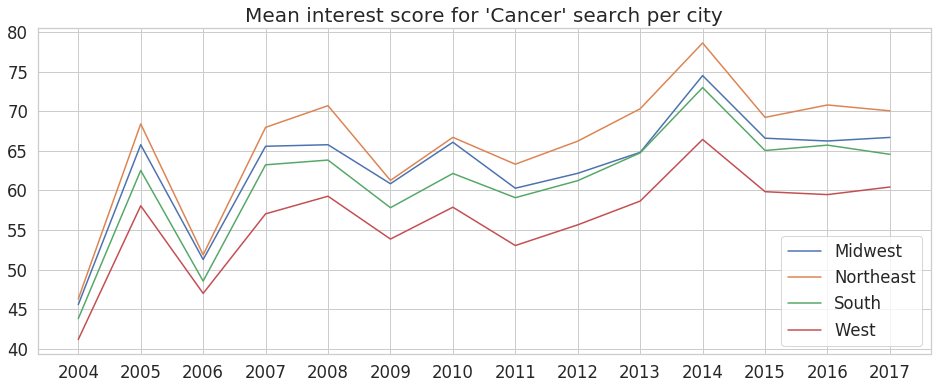

In [41]:
plt.figure(figsize=(16, 6))
ax = plt.subplot(111)
plt.title("Mean interest score for 'Cancer' search per city", fontsize=20)

ax.set_xticks(range(0,14))
ax.set_xticklabels(list(mean_dict['cancer'].keys()))

tempList = list(mean_dict['cancer'].values())
_= plt.plot(tempList)

plt.legend(mean_dict['cancer']['2005'].keys(), loc='best')

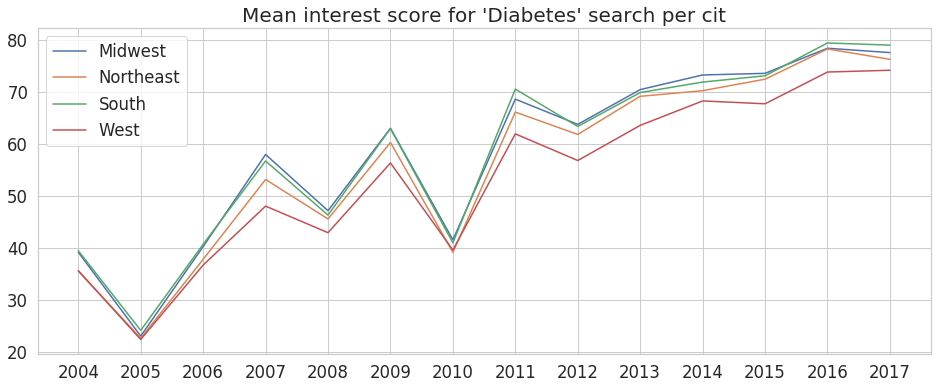

In [42]:
plt.figure(figsize=(16, 6))
ax = plt.subplot(111)
plt.title("Mean interest score for 'Diabetes' search per cit", fontsize=20)

ax.set_xticks(range(0,14))
ax.set_xticklabels(list(mean_dict['diabetes'].keys()))

tempList = list(mean_dict['diabetes'].values())
_= plt.plot(tempList)

plt.legend(mean_dict['diabetes']['2005'].keys(), loc='best')

In [43]:
cancer_df = pd.DataFrame(mean_dict['cancer']).T
cancer_df

region,Midwest,Northeast,South,West
2004,45.588235,46.304348,43.816092,41.183673
2005,65.764706,68.391304,62.517241,58.061224
2006,51.274510,51.869565,48.551724,47.000000
2007,65.568627,67.956522,63.229885,57.040816
2008,65.764706,70.695652,63.827586,59.265306
2009,60.843137,61.260870,57.816092,53.857143
2010,66.078431,66.695652,62.137931,57.877551
2011,60.274510,63.304348,59.080460,53.040816
2012,62.156863,66.217391,61.229885,55.653061
2013,64.803922,70.304348,64.735632,58.653061


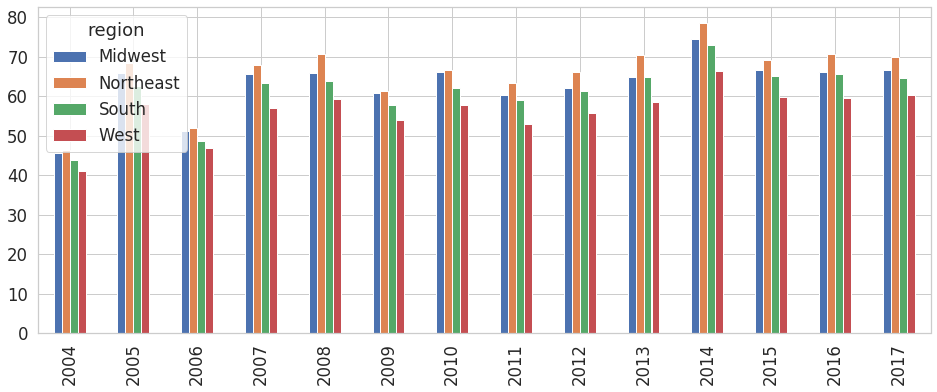

In [44]:
cancer_df.plot(kind='bar', figsize=(16,6))

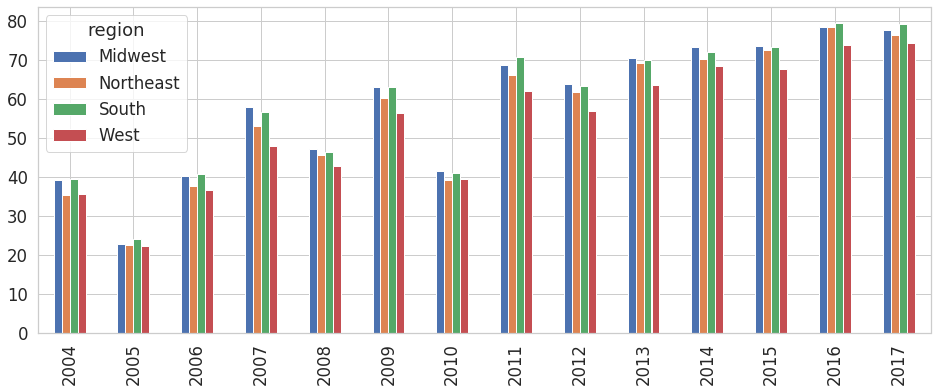

In [45]:
diabetes_df = pd.DataFrame(mean_dict['diabetes']).T
diabetes_df.plot(kind='bar', figsize=(16,6))

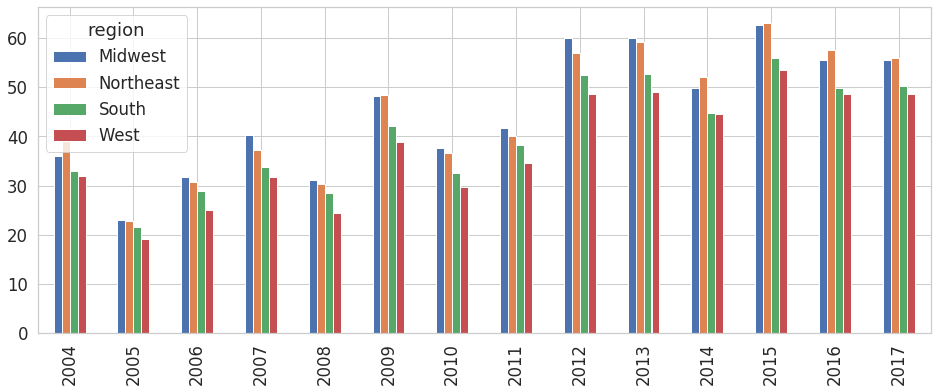

In [46]:
obesity_df = pd.DataFrame(mean_dict['obesity']).T
obesity_df.plot(kind='bar', figsize=(16,6))

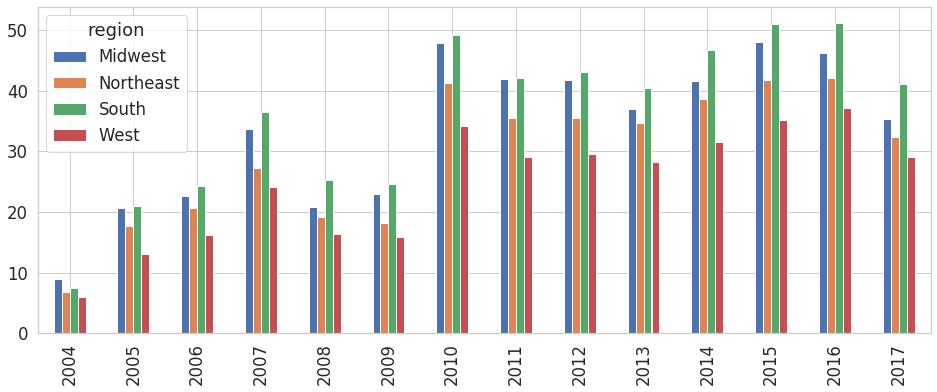

In [47]:
cardio_df = pd.DataFrame(mean_dict['cardiovascular']).T
cardio_df.plot(kind='bar', figsize=(16,6))

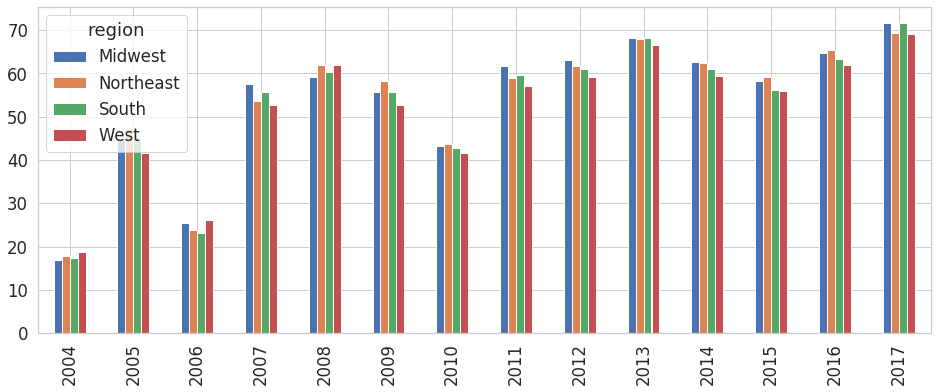

In [48]:
stroke_df = pd.DataFrame(mean_dict['stroke']).T
stroke_df.plot(kind='bar', figsize=(16,6))

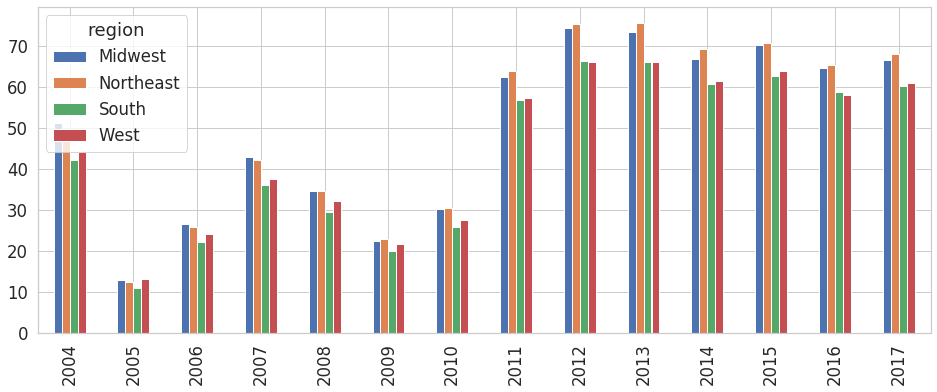

In [49]:
depr_df = pd.DataFrame(mean_dict['depression']).T
depr_df.plot(kind='bar', figsize=(16,6))

# Median Interest

In [50]:
# Regional median search count per city
region_med = healthSearchData.groupby('region').median()
region_med

,2004+cancer,2004+cardiovascular,2004+stroke,2004+depression,2004+rehab,2004+vaccine,2004+diarrhea,2004+obesity,2004+diabetes,2005+cancer,2005+cardiovascular,2005+stroke,2005+depression,2005+rehab,2005+vaccine,2005+diarrhea,2005+obesity,2005+diabetes,2006+cancer,2006+cardiovascular,2006+stroke,2006+depression,2006+rehab,2006+vaccine,2006+diarrhea,2006+obesity,2006+diabetes,2007+cancer,2007+cardiovascular,2007+stroke,2007+depression,2007+rehab,2007+vaccine,2007+diarrhea,2007+obesity,2007+diabetes,2008+cancer,2008+cardiovascular,2008+stroke,2008+depression,...,2013+vaccine,2013+diarrhea,2013+obesity,2013+diabetes,2014+cancer,2014+cardiovascular,2014+stroke,2014+depression,2014+rehab,2014+vaccine,2014+diarrhea,2014+obesity,2014+diabetes,2015+cancer,2015+cardiovascular,2015+stroke,2015+depression,2015+rehab,2015+vaccine,2015+diarrhea,2015+obesity,2015+diabetes,2016+cancer,2016+cardiovascular,2016+stroke,2016+depression,2016+rehab,2016+vaccine,2016+diarrhea,2016+obesity,2016+diabetes,2017+cancer,2017+cardiovascular,2017+stroke,2017+depression,2017+rehab,2017+vaccine,2017+diarrhea,2017+obesity,2017+diabetes
region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Midwest,45,7,15,49,16,32,15,32,38,64,17,45,13,22,28,24,23,23,51,20,24,26,29,37,43,30,39,65,32,57,44,30,42,20,40,56,66,19,59,35,...,63,69,57,70,75,40,61,67,55,64,69,49,73,67,47,57,69,51,64,73,60,73,65,44,64,64,45,64,75,52,78,65,34,70,66,45,74,76,53,77
Northeast,47,6,17,49,20,37,14,34,36,67,16,45,12,25,32,25,20,22,53,20,24,25,35,42,41,29,38,68,30,54,41,38,44,20,37,54,69,20,61,34,...,69,67,58,69,79,38,62,69,69,67,66,48,71,69,44,57,69,62,70,71,60,72,71,41,64,65,54,70,74,53,78,70,34,68,66,57,80,72,57,75
South,43,7,16,40,19,29,14,31,38,63,17,44,11,26,27,24,19,23,48,22,23,22,34,35,41,27,39,64,34,56,36,37,39,21,32,55,64,23,61,29,...,61,69,54,70,73,44,63,61,65,59,70,42,72,66,49,58,64,61,57,70,56,74,65,48,64,58,57,58,73,49,79,65,39,73,60,58,69,71,49,79
West,41,5,17,42,15,30,13,30,34,57,12,43,11,20,26,23,18,21,45,16,24,22,25,35,40,25,36,58,24,54,37,30,37,17,32,50,58,16,63,30,...,60,64,52,65,67,33,59,63,50,63,65,45,69,59,37,55,64,47,68,67,57,70,59,38,60,58,42,64,70,51,75,59,29,70,61,43,75,68,50,76


In [0]:
# Maybe plot proportions?

In [0]:
# Bar plot? Stacked bar plot?

# From Kaggle kernel

In [0]:
# From Kaggle kernel

In [0]:
# Check for null values

for col in healthSearchData.columns:
  bool_series = pd.isnull(healthSearchData[col])
  if len(healthSearchData[bool_series].index.values) != 0:
    print(healthSearchData[bool_series].index.values)


In [55]:
healthSearchData.describe().T

,count,mean,std,min,25%,50%,75%,max
2004+cancer,210.0,43.904762,7.618944,27.0,40.00,43.0,47.0,100.0
2004+cardiovascular,210.0,7.433333,7.909647,0.0,5.00,6.0,9.0,100.0
2004+stroke,210.0,17.642857,8.135284,0.0,14.00,16.0,18.0,100.0
2004+depression,210.0,45.623810,13.715720,0.0,37.00,44.0,51.0,100.0
2004+rehab,210.0,18.890476,10.157723,0.0,15.00,17.0,21.0,100.0
...,...,...,...,...,...,...,...,...
2017+rehab,210.0,52.928571,14.795242,0.0,43.00,51.0,61.0,100.0
2017+vaccine,210.0,72.800000,10.983154,0.0,67.00,73.0,79.0,100.0
2017+diarrhea,210.0,72.723810,10.453813,0.0,67.00,72.0,78.0,100.0
2017+obesity,210.0,51.761905,13.846751,0.0,45.25,51.0,58.0,100.0


In [56]:
healthSearchData.head()

,dma,2004+cancer,2004+cardiovascular,2004+stroke,2004+depression,2004+rehab,2004+vaccine,2004+diarrhea,2004+obesity,2004+diabetes,2005+cancer,2005+cardiovascular,2005+stroke,2005+depression,2005+rehab,2005+vaccine,2005+diarrhea,2005+obesity,2005+diabetes,2006+cancer,2006+cardiovascular,2006+stroke,2006+depression,2006+rehab,2006+vaccine,2006+diarrhea,2006+obesity,2006+diabetes,2007+cancer,2007+cardiovascular,2007+stroke,2007+depression,2007+rehab,2007+vaccine,2007+diarrhea,2007+obesity,2007+diabetes,2008+cancer,2008+cardiovascular,2008+stroke,...,2013+obesity,2013+diabetes,2014+cancer,2014+cardiovascular,2014+stroke,2014+depression,2014+rehab,2014+vaccine,2014+diarrhea,2014+obesity,2014+diabetes,2015+cancer,2015+cardiovascular,2015+stroke,2015+depression,2015+rehab,2015+vaccine,2015+diarrhea,2015+obesity,2015+diabetes,2016+cancer,2016+cardiovascular,2016+stroke,2016+depression,2016+rehab,2016+vaccine,2016+diarrhea,2016+obesity,2016+diabetes,2017+cancer,2017+cardiovascular,2017+stroke,2017+depression,2017+rehab,2017+vaccine,2017+diarrhea,2017+obesity,2017+diabetes,state_abbrev,region
0,Portland-Auburn ME,44,6,17,39,21,31,14,29,38,70,16,38,11,27,36,26,14,23,55,23,26,25,38,48,48,19,44,70,31,56,38,37,42,22,24,56,68,22,66,...,52,66,79,44,70,72,70,72,61,51,75,67,43,61,70,67,64,68,48,73,69,38,70,64,60,64,69,49,81,70,37,83,64,56,76,66,47,80,ME,Northeast
1,New York NY,47,6,13,38,16,33,12,27,32,63,15,35,10,22,29,23,15,19,49,18,18,20,26,38,37,22,33,64,29,43,34,36,41,18,26,48,64,18,48,...,44,58,71,33,45,53,58,57,56,39,62,64,36,44,55,53,58,56,46,63,68,41,47,53,51,64,57,49,77,70,34,53,56,53,79,56,52,78,NY,Northeast
2,Binghamton NY,48,3,16,50,12,37,24,31,37,62,8,44,13,25,21,23,24,18,54,19,26,27,20,35,34,30,26,61,20,56,43,28,45,25,43,54,65,15,62,...,52,70,80,36,63,74,50,66,75,65,72,64,31,59,69,46,73,84,67,75,74,33,66,66,44,72,79,70,74,68,24,71,69,44,77,78,61,72,NY,Northeast
3,Macon GA,44,14,14,37,19,49,14,29,31,55,25,48,10,29,33,22,23,22,44,24,23,18,39,50,46,29,39,65,42,54,35,40,42,16,36,48,66,23,58,...,62,64,72,56,69,60,71,53,68,54,78,66,60,62,68,66,53,71,60,73,63,59,65,56,69,56,66,51,78,53,38,62,46,60,47,53,41,66,GA,South
4,Philadelphia PA,52,7,16,41,23,36,14,30,37,73,17,39,12,32,33,24,18,23,57,24,23,23,40,42,44,24,40,72,34,49,38,46,47,21,31,55,75,23,59,...,51,68,81,39,57,62,83,68,66,44,70,71,45,51,63,77,69,67,56,72,74,42,56,59,72,70,70,52,80,75,35,61,62,75,84,69,56,78,PA,Northeast


The below plots and code I downloaded and adapted a bit from a kernel on Kaggle, I thought figures were great for general overview of the data.

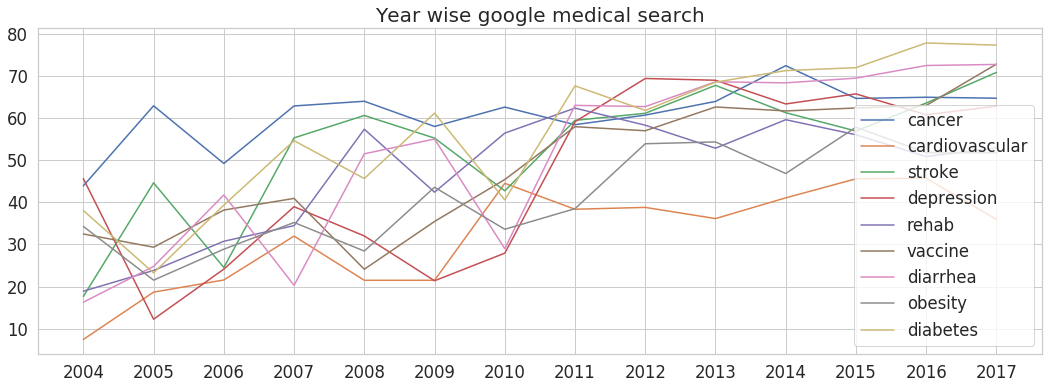

In [57]:
# Average number of searches per city / location

yearWiseMeam = {}
for col in healthSearchData.columns:
    if '+' in col:
        year = col.split('+')[0]
        disease = col.split('+')[-1]
        if not disease in yearWiseMeam:
            yearWiseMeam[disease] = {}
        if not year in yearWiseMeam[disease]:
            yearWiseMeam[disease][year] = np.mean(list(healthSearchData[col]))

plt.figure(figsize=(18, 6))
ax = plt.subplot(111)
plt.title("Year wise google medical search", fontsize=20)

ax.set_xticks(range(0,14))
ax.set_xticklabels(list(yearWiseMeam['cancer'].keys()))
lh = {}
for disease in yearWiseMeam:
    tempList = list(yearWiseMeam[disease].values())
    lh[disease] = plt.plot(tempList)
plt.legend(lh, loc='best')

In [58]:
yearWiseMeam

{'cancer': {'2004': 43.904761904761905,
  '2005': 62.90952380952381,
  '2006': 49.214285714285715,
  '2007': 62.871428571428574,
  '2008': 63.98571428571429,
  '2009': 58.00476190476191,
  '2010': 62.6,
  '2011': 58.423809523809524,
  '2012': 60.7,
  '2013': 63.94285714285714,
  '2014': 72.43333333333334,
  '2015': 64.65714285714286,
  '2016': 64.93809523809524,
  '2017': 64.70952380952382},
 'cardiovascular': {'2004': 7.433333333333334,
  '2005': 18.67142857142857,
  '2006': 21.557142857142857,
  '2007': 31.976190476190474,
  '2008': 21.48095238095238,
  '2009': 21.485714285714284,
  '2010': 44.50476190476191,
  '2011': 38.34761904761905,
  '2012': 38.79047619047619,
  '2013': 36.13333333333333,
  '2014': 41.05238095238095,
  '2015': 45.58095238095238,
  '2016': 45.72857142857143,
  '2017': 35.923809523809524},
 'depression': {'2004': 45.62380952380953,
  '2005': 12.242857142857142,
  '2006': 24.133333333333333,
  '2007': 38.94761904761905,
  '2008': 32.00952380952381,
  '2009': 21.37

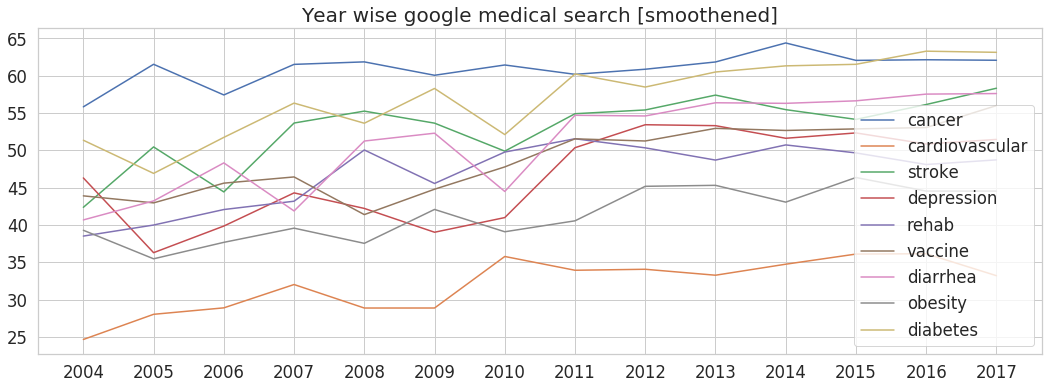

In [65]:
plt.figure(figsize=(18, 6))
ax = plt.subplot(111)
plt.title("Year wise google medical search [smoothened]", fontsize=20)

ax.set_xticks(range(0,14))
ax.set_xticklabels(list(yearWiseMeam['cancer'].keys()))
lh = {}
myLambda = 0.7
for disease in yearWiseMeam:
    tempList = list(yearWiseMeam[disease].values())
    localMean = np.mean(tempList)
    smoothList = []
    for x in tempList:
        smoothList.append(x + myLambda * (localMean - x)) 
    lh[disease] = plt.plot(smoothList)
plt.legend(lh, loc='best')

In [0]:
#yearWiseMeam

In [0]:
df = pd.DataFrame(yearWiseMeam)

df['yr_total'] = df.sum(axis=1, skipna=True)



In [62]:
df

,cancer,cardiovascular,stroke,depression,rehab,vaccine,diarrhea,obesity,diabetes,yr_total
2004,43.904762,7.433333,17.642857,45.623810,18.890476,32.476190,16.280952,34.261905,38.042857,254.557143
2005,62.909524,18.671429,44.619048,12.242857,23.823810,29.342857,24.771429,21.519048,23.238095,261.138095
2006,49.214286,21.557143,24.519048,24.133333,30.747619,38.152381,41.747619,28.871429,39.323810,298.266667
2007,62.871429,31.976190,55.290476,38.947619,34.461905,40.928571,20.285714,35.204762,54.628571,374.595238
2008,63.985714,21.480952,60.609524,32.009524,57.352381,24.104762,51.514286,28.423810,45.642857,385.123810
2009,58.004762,21.485714,55.238095,21.371429,42.395238,35.447619,55.019048,43.571429,61.171429,393.704762
2010,62.600000,44.504762,42.728571,27.919048,56.419048,45.404762,28.990476,33.595238,40.576190,382.738095
2011,58.423810,38.347619,59.452381,59.133333,62.361905,57.947619,63.014286,38.485714,67.638095,504.804762
2012,60.700000,38.790476,61.133333,69.390476,58.300000,56.985714,62.714286,53.900000,61.800000,523.714286
2013,63.942857,36.133333,67.761905,68.971429,52.838095,62.628571,68.609524,54.333333,68.523810,543.742857


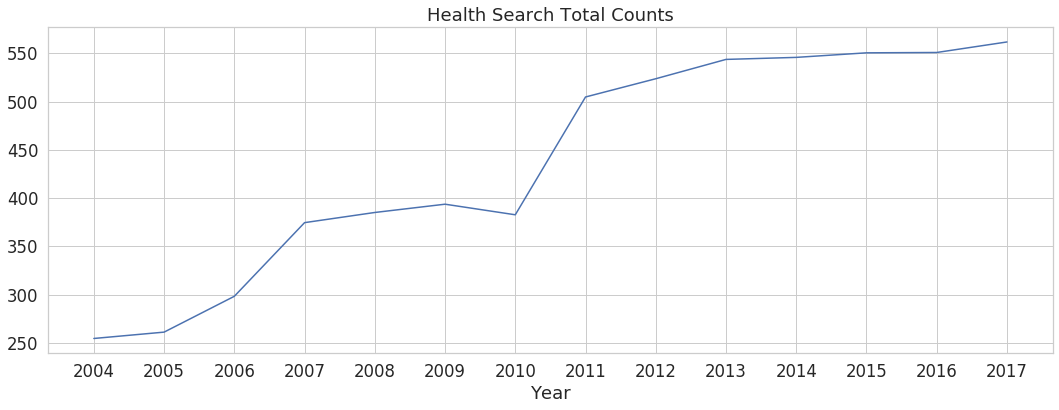

In [63]:
plt.figure(figsize=(18, 6))
_=plt.plot(df['yr_total'])
_=plt.title('Health Search Total Counts')
_=plt.xlabel('Year')


In [64]:
statesData = pd.DataFrame(healthSearchData.iloc[:,0])
healthSearchData = healthSearchData.drop(['dma'],axis=1)

meanDict = {}
yearList = []
illnessList = []
for col in healthSearchData.columns:
    if '+' in col:
        yearList.append(col.split('+')[0])
        illnessList.append(col.split('+')[-1])
        
for index, row in healthSearchData.iterrows():
    for illness in illnessList:
        searchCountList = []
        for year in yearList:
            searchCountList.append(row[year+ '+' +illness])
        if not illness in meanDict:
            meanDict[illness] = []
        meanDict[illness].append(np.mean(searchCountList))
yearWiseMeanDf = pd.DataFrame.from_dict(meanDict, orient='columns', dtype=None)
heatMapData = statesData.join(yearWiseMeanDf)
heatMapData.set_index('dma', inplace=True, drop=True)
heatMapData.style.background_gradient(cmap='coolwarm')